In [1]:
# inversion calculation

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re
import cartopy.crs as ccrs
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script

In [9]:
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'
output_directory = input_directory
xco2_file = 'XCO2_model.nc'
inversion_file = 'inversion.nc'

# Name of output netCDF file
output_file = 'posterior.nc'

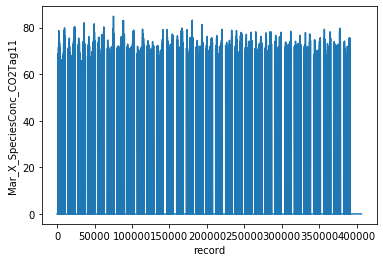

In [29]:
ds_xco2_model = xr.open_dataset(input_directory + xco2_file)
varnames = list(ds_xco2_model.data_vars.keys())
#varnames[47:69]
#ds_xco2_model['Mar_X_SpeciesConc_CO2Tag11'].plot()

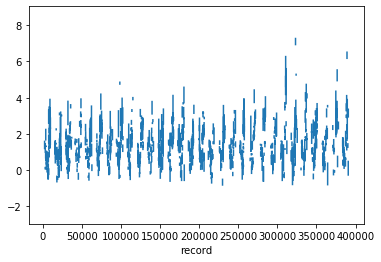

In [34]:
ds_inversion = xr.open_dataset(input_directory + inversion_file)
diff = ds_inversion['xco2_oco2'] - ds_inversion['xco2_model']
diff.plot()

In [35]:
# reduce the size of array and matrix
xco2_oco2 = ds_xco2_model['xco2_obs']
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values

In [36]:
diff_slice = diff[ind].values
np.shape(diff_slice)

(10588,)

In [37]:
del_Y_matrix = np.empty((len(ind),22))
del_Y_matrix[:] = np.nan
np.shape(del_Y_matrix)
for itag in range(22):
    name_var = 'Mar_X_SpeciesConc_CO2Tag' + str(itag+1)
    del_Y_matrix[:,itag] = ds_xco2_model[name_var][ind].values

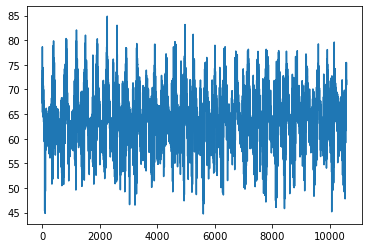

In [38]:
plt.plot(del_Y_matrix[:,1])

In [39]:
del_Y_tran = np.matrix.transpose(del_Y_matrix)
k_e = np.linalg.inv(np.matmul(del_Y_matrix, del_Y_tran) + 2)
k_e = np.matmul(del_Y_tran, k_e)
np.shape(k_e)

(22, 10588)

In [43]:
adjust = np.matmul(k_e, diff_slice)
#plt.plot(adjust)
len(adjust)

22

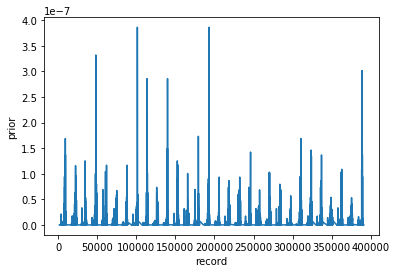

In [41]:
ds_inversion['prior'][ind].plot()